In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report

In [ ]:
from rdkit import Chem
from rdkit.Chem import AllChem

In [ ]:
pip install -q pyrfume

In [ ]:
import pyrfume

In [ ]:
molecules = pyrfume.load_data('dravnieks_1985/molecules.csv')
dravnieks_behavior = pyrfume.load_data("dravnieks_1985/behavior_2.csv")
dravnieks_stimuli = pyrfume.load_data("dravnieks_1985/stimuli.csv")

In [ ]:
"""Beginning of Supervised Task"""
#Creating a Matrix of molecules (ethanol, pyrazine, etc..) by features ('fresh', 'minty', etc...)
df = (pd
      .merge(dravnieks_behavior, dravnieks_stimuli, left_index=True, right_index=True)
      .dropna(subset=['CID']) #drop molecules with no cids
      )


df.index.str.rstrip('_high')


#Merge molecule info together
df =  df.drop_duplicates(subset=['CID']) #drop duplicates
#Create binary Y-lists, threshold of 15
descriptor_columns = df.columns[:146]
df[descriptor_columns] = (df[descriptor_columns] > 15).astype(int)
df

,"FRUITY,CITRUS",LEMON,GRAPEFRUIT,ORANGE,"FRUITY,OTHER THAN CITRUS",PINEAPPLE,GRAPE JUICE,STRAWBERRY,"APPLE, FRUIT",PEAR,...,"DRY, POWDERY",CHALKY,LIGHT,HEAVY,"COOL,COOLING",WARM,CAS,CID,Conc,Name
Stimulus,,,,,,,,,,,,,,,,,,,,,
Abhexone_high,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,698-10-2,61199.0,high,Abhexone
Acetophenone_high,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,1,1,98-86-2,7410.0,high,Acetophenone
AcetylPyridine_high,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,1,1122-62-9,14286.0,high,AcetylPyridine
Adoxal_high,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,141-13-9,98403.0,high,Adoxal
AldehydeC-16highcon_high,1,0,0,0,1,0,0,1,0,0,...,0,0,1,0,1,0,77-83-8,6501.0,high,AldehydeC-16highcon
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ValericAcid-iso_high,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,503-74-2,10430.0,high,ValericAcid-iso
Valerolactonegamma_high,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,108-29-2,7921.0,high,Valerolactonegamma
Vanillin_high,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,1,121-33-5,1183.0,high,Vanillin


In [ ]:
#meging it
df = pd.merge(df, molecules[['IUPACName', 'IsomericSMILES', 'MolecularWeight']], left_on='CID', right_index=True, how='left')

In [ ]:
df['IsomericSMILES']

,IsomericSMILES
Stimulus,
Abhexone_high,CCC1C(=C(C(=O)O1)O)C
Acetophenone_high,CC(=O)C1=CC=CC=C1
AcetylPyridine_high,CC(=O)C1=CC=CC=N1
Adoxal_high,CC(CCCC(C)C=O)CCC=C(C)C
AldehydeC-16highcon_high,CCOC(=O)C1C(O1)(C)C2=CC=CC=C2
...,...
ValericAcid-iso_high,CC(C)CC(=O)O
Valerolactonegamma_high,CC1CCC(=O)O1
Vanillin_high,COC1=C(C=CC(=C1)C=O)O


In [ ]:
#Function helping us get the total bond energies
def calculate_total_bond_energy(smiles):
    molecule = Chem.MolFromSmiles(smiles)
    if molecule is None:
        return np.nan

    total_bond_energy = 0
    for bond in molecule.GetBonds():
        atom1 = bond.GetBeginAtom().GetSymbol()
        atom2 = bond.GetEndAtom().GetSymbol()
        bond_type = bond.GetBondType()

        if bond_type == Chem.rdchem.BondType.SINGLE:
            key = f"{atom1}-{atom2}" if f"{atom1}-{atom2}" in BDE_VALUES else f"{atom2}-{atom1}"
        elif bond_type == Chem.rdchem.BondType.DOUBLE:
            key = f"{atom1}={atom2}" if f"{atom1}={atom2}" in BDE_VALUES else f"{atom2}={atom1}"
        elif bond_type == Chem.rdchem.BondType.TRIPLE:
            key = f"{atom1}#${atom2}" if f"{atom1}#${atom2}" in BDE_VALUES else f"{atom2}#${atom1}"
        else:
            continue

        total_bond_energy += BDE_VALUES.get(key, 0)

    return total_bond_energy


In [ ]:
#Defines bond energies/dissociation energy, BDE, values for specific bonds, the ones your'e most likely to find in fragrances humans can safely smell
#we're not worried about bonds like Pb-C, only a mad scientist would be curious about those types of fragrances
BDE_VALUES = {
    "C-H": 412, "C-C": 348, "C=C": 614, "C#C": 839,
    "O-H": 464, "C-O": 358, "C=O": 799, "N-H": 391,
    "C-N": 305, "C-F": 485, "C-Cl": 338, "C-Br": 276,
    "C-I": 238
}

df['TotalBondEnergy'] = df['IsomericSMILES'].apply(calculate_total_bond_energy)
df['TotalBondEnergy']

,TotalBondEnergy
Stimulus,
Abhexone_high,4227
Acetophenone_high,1495
AcetylPyridine_high,1495
Adoxal_high,5589
AldehydeC-16highcon_high,3971
...,...
ValericAcid-iso_high,2549
Valerolactonegamma_high,2907
Vanillin_high,2221


In [ ]:
df_new = df.drop(['CAS','CID','Conc','Name','IUPACName','IsomericSMILES','MolecularWeight'], axis =1)
#Drop cols where all the vals are 0
df_new = df_new.loc[:, (df != 0).any(axis=0)]
df_new.columns.tolist()
df_new.mean()
#Checking where full columns are 0 for determining th
np.where(df_new.mean() == 0)

(array([], dtype=int64),)

In [ ]:
df_sorted = df_new.sort_values(by='TotalBondEnergy')
df_sorted['TotalBondEnergy']

,TotalBondEnergy
Stimulus,
Thienopyrimidine_high,0
Indole_high,0
Pyridine_high,0
Thiophene_high,0
DimethylTrisulfide_high,0
...,...
Santalol_high,6540
Sandiff_high,6622
Andrane_high,6632


In [ ]:
#Splitting TotalBondEnergy into negative and positive sets
negative_values = df_new['TotalBondEnergy'][df_new['TotalBondEnergy'] < 0]
positive_values = df_new['TotalBondEnergy'][df_new['TotalBondEnergy'] >= 0]

#Handleing negative quartiles
if len(negative_values) > 1 and negative_values.nunique() > 1:
    neg_quartiles, neg_bins = pd.qcut(
        negative_values, q=4, retbins=True, labels=['-Q4', '-Q3', '-Q2', '-Q1']
    )
else:
    neg_bins = np.array([float('-inf'), -75, -50, -25, 0])
    neg_quartiles = pd.cut(negative_values, bins=neg_bins, labels=['-Q4', '-Q3', '-Q2', '-Q1'])

#Handleing positive quartiles
if len(positive_values) > 1 and positive_values.nunique() > 1:
    pos_quartiles, pos_bins = pd.qcut(
        positive_values, q=4, retbins=True, labels=['Q1', 'Q2', 'Q3', 'Q4']
    )
else:
    pos_bins = np.array([0, 25, 50, 75, float('inf')])
    pos_quartiles = pd.cut(positive_values, bins=pos_bins, labels=['Q1', 'Q2', 'Q3', 'Q4'])

#Merge them bins
all_bins = np.concatenate((neg_bins, pos_bins[1:]))  #Combines negative and positive bins, avoids duplicate 0s

#A big book to store descriptors in by bin
bin_descriptors = {'-Q4': [], '-Q3': [], '-Q2': [], '-Q1': [], 'Q1': [], 'Q2': [], 'Q3': [], 'Q4': []}

#"Initialize logistic the regression model"!!
model = LogisticRegression()

#Iterates through the descriptors
for descriptor in df_new.columns[:-1]:  #Exclude 'TotalBondEnergy'
    X = df_new[['TotalBondEnergy']].values
    y = df_new[descriptor].values

    #Fit that thang
    model.fit(X, y)

    #Calculate boundary for decision
    beta_0 = model.intercept_[0]  #Intercept
    beta_1 = model.coef_[0][0]    #Coefficient

    if beta_1 != 0:  #Avoid division by zero, that breaks the universe or something
        decision_boundary = -beta_0 / beta_1

        #Which bin
        for i in range(len(all_bins) - 1):
            if all_bins[i] <= decision_boundary <= all_bins[i + 1]:
                #Assign to the appropriate bin
                if i < 4:  #First 4 bins are negative
                    bin_label = f"-Q{4 - i}"
                else:  #Rest of the bins are positive
                    bin_label = f"Q{i - 3}"

                bin_descriptors[bin_label].append(descriptor)
                break

#results...
for bin_label, descriptors in bin_descriptors.items():
    print(f"{bin_label}: {descriptors}")



-Q4: ['PEACH FRUIT', 'VIOLETS', 'AROMATIC', 'ALMOND', 'NAIL POLISH REMOVER', 'NUTTY, WALNUT ETC.', 'CINNAMON', 'GREEN PEPPER', 'WOODY, RESINOUS', 'MOTHBALLS', 'CHOCOLATE', 'VANILLA', 'MALTY', 'ANISE, LICORICE', 'ALCOHOLIC', 'ETHERISH, ANAESTHETIC', 'CLEANING FLUID', 'GASOLINE, SOLVENT', 'TURPENTINE, PINE OIL', 'FRESH GREEN VEGETABLES', 'CRUSHED WEEDS', 'CRUSHED GRASS', 'GRAINY (AS GRAIN)', 'YEASTY', 'SOUR MILK', 'LEATHER', 'DIRTY LINEN', 'STALE', 'RAW POTATO', 'MUSHROOM', 'PEANUT BUTTER', 'BARK,BIRCHBARK', 'BURNT PAPER', 'BURNT RUBBER', 'TAR', 'CREOSOTE', 'DISINFECTANT, CARBOLIC', 'MEDICINAL', 'SOUR, VINEGAR', 'AMMONIA', 'URINE', 'CAT URINE', 'FISHY', 'KIPPERY,SMOKED FISH', 'KEROSENE', 'BUTTERY, FRESH BUTTER', 'PAINT', 'VARNISH', 'POPCORN', 'MEATY ( COOKED,GOOD)', 'COOKED VEGETABLES', 'RANCID', 'SWEATY', 'HOUSEHOLD GAS', 'SULFIDIC', 'GARLIC, ONION', 'BLOOD, RAW MEAT', 'ANIMAL', 'SEWER', 'PUTRID, FOUL, DECAYED', 'FECAL, LIKE MANURE', 'CADAVEROUS', 'CHALKY', 'WARM']
-Q3: []
-Q2: []
-Q1: 

In [ ]:
"""Beginning of Unsupervised Task"""
#Matrix of the molecules,(ethanol, pyrazine, etc..) x features ('fresh', 'minty', etc...)
#were doing this again for kmeans cause the new df was only 1s and 0s, needed to put it back and do the merge again
df_km = (pd
      .merge(dravnieks_behavior, dravnieks_stimuli, left_index=True, right_index=True)
      .dropna(subset=['CID']) #drop molecules w/ no cids
      )

df_km.index.str.rstrip('_high')

df_km =df_km.drop_duplicates(subset=['CID']) # drop duplicate molecules

In [ ]:
#merging again
df_km = pd.merge(df_km, molecules[['IUPACName', 'IsomericSMILES', 'MolecularWeight']], left_on='CID', right_index=True, how='left')

In [ ]:
df_km['TotalBondEnergy'] = df_km['IsomericSMILES'].apply(calculate_total_bond_energy)
df_km['TotalBondEnergy']

,TotalBondEnergy
Stimulus,
Abhexone_high,4227
Acetophenone_high,1495
AcetylPyridine_high,1495
Adoxal_high,5589
AldehydeC-16highcon_high,3971
...,...
ValericAcid-iso_high,2549
Valerolactonegamma_high,2907
Vanillin_high,2221


In [ ]:
df_km = df_km.drop(['CAS','CID','Conc','Name','IUPACName','IsomericSMILES','MolecularWeight'], axis =1)
#Drop that column if it ain't got a zero
df_km = df_km.loc[:, (df != 0).any(axis=0)]

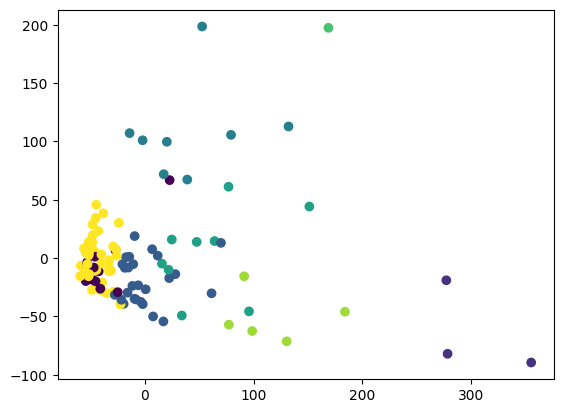

In [ ]:
from sklearn.decomposition import PCA
ratings_matrix = df_km.set_index('TotalBondEnergy').T
X = ratings_matrix.values
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
kmeans = KMeans(n_clusters = 8, random_state = 42)
kmeans.fit(X)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels_)
#shes a wee bit cluttered, but kinda reminds me of that iris one

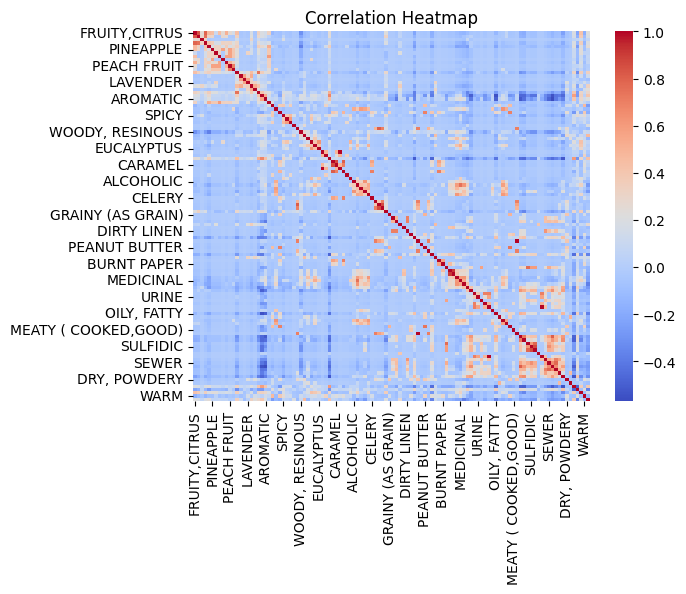

In [ ]:
"""Beginning of Exploratory Data Analysis"""
#A snazzy heatmap, kinda leaves out a few things though right?
correlations = df_new.corr()
sns.heatmap(correlations, cmap="coolwarm", annot=False)
plt.title("Correlation Heatmap")
plt.show()

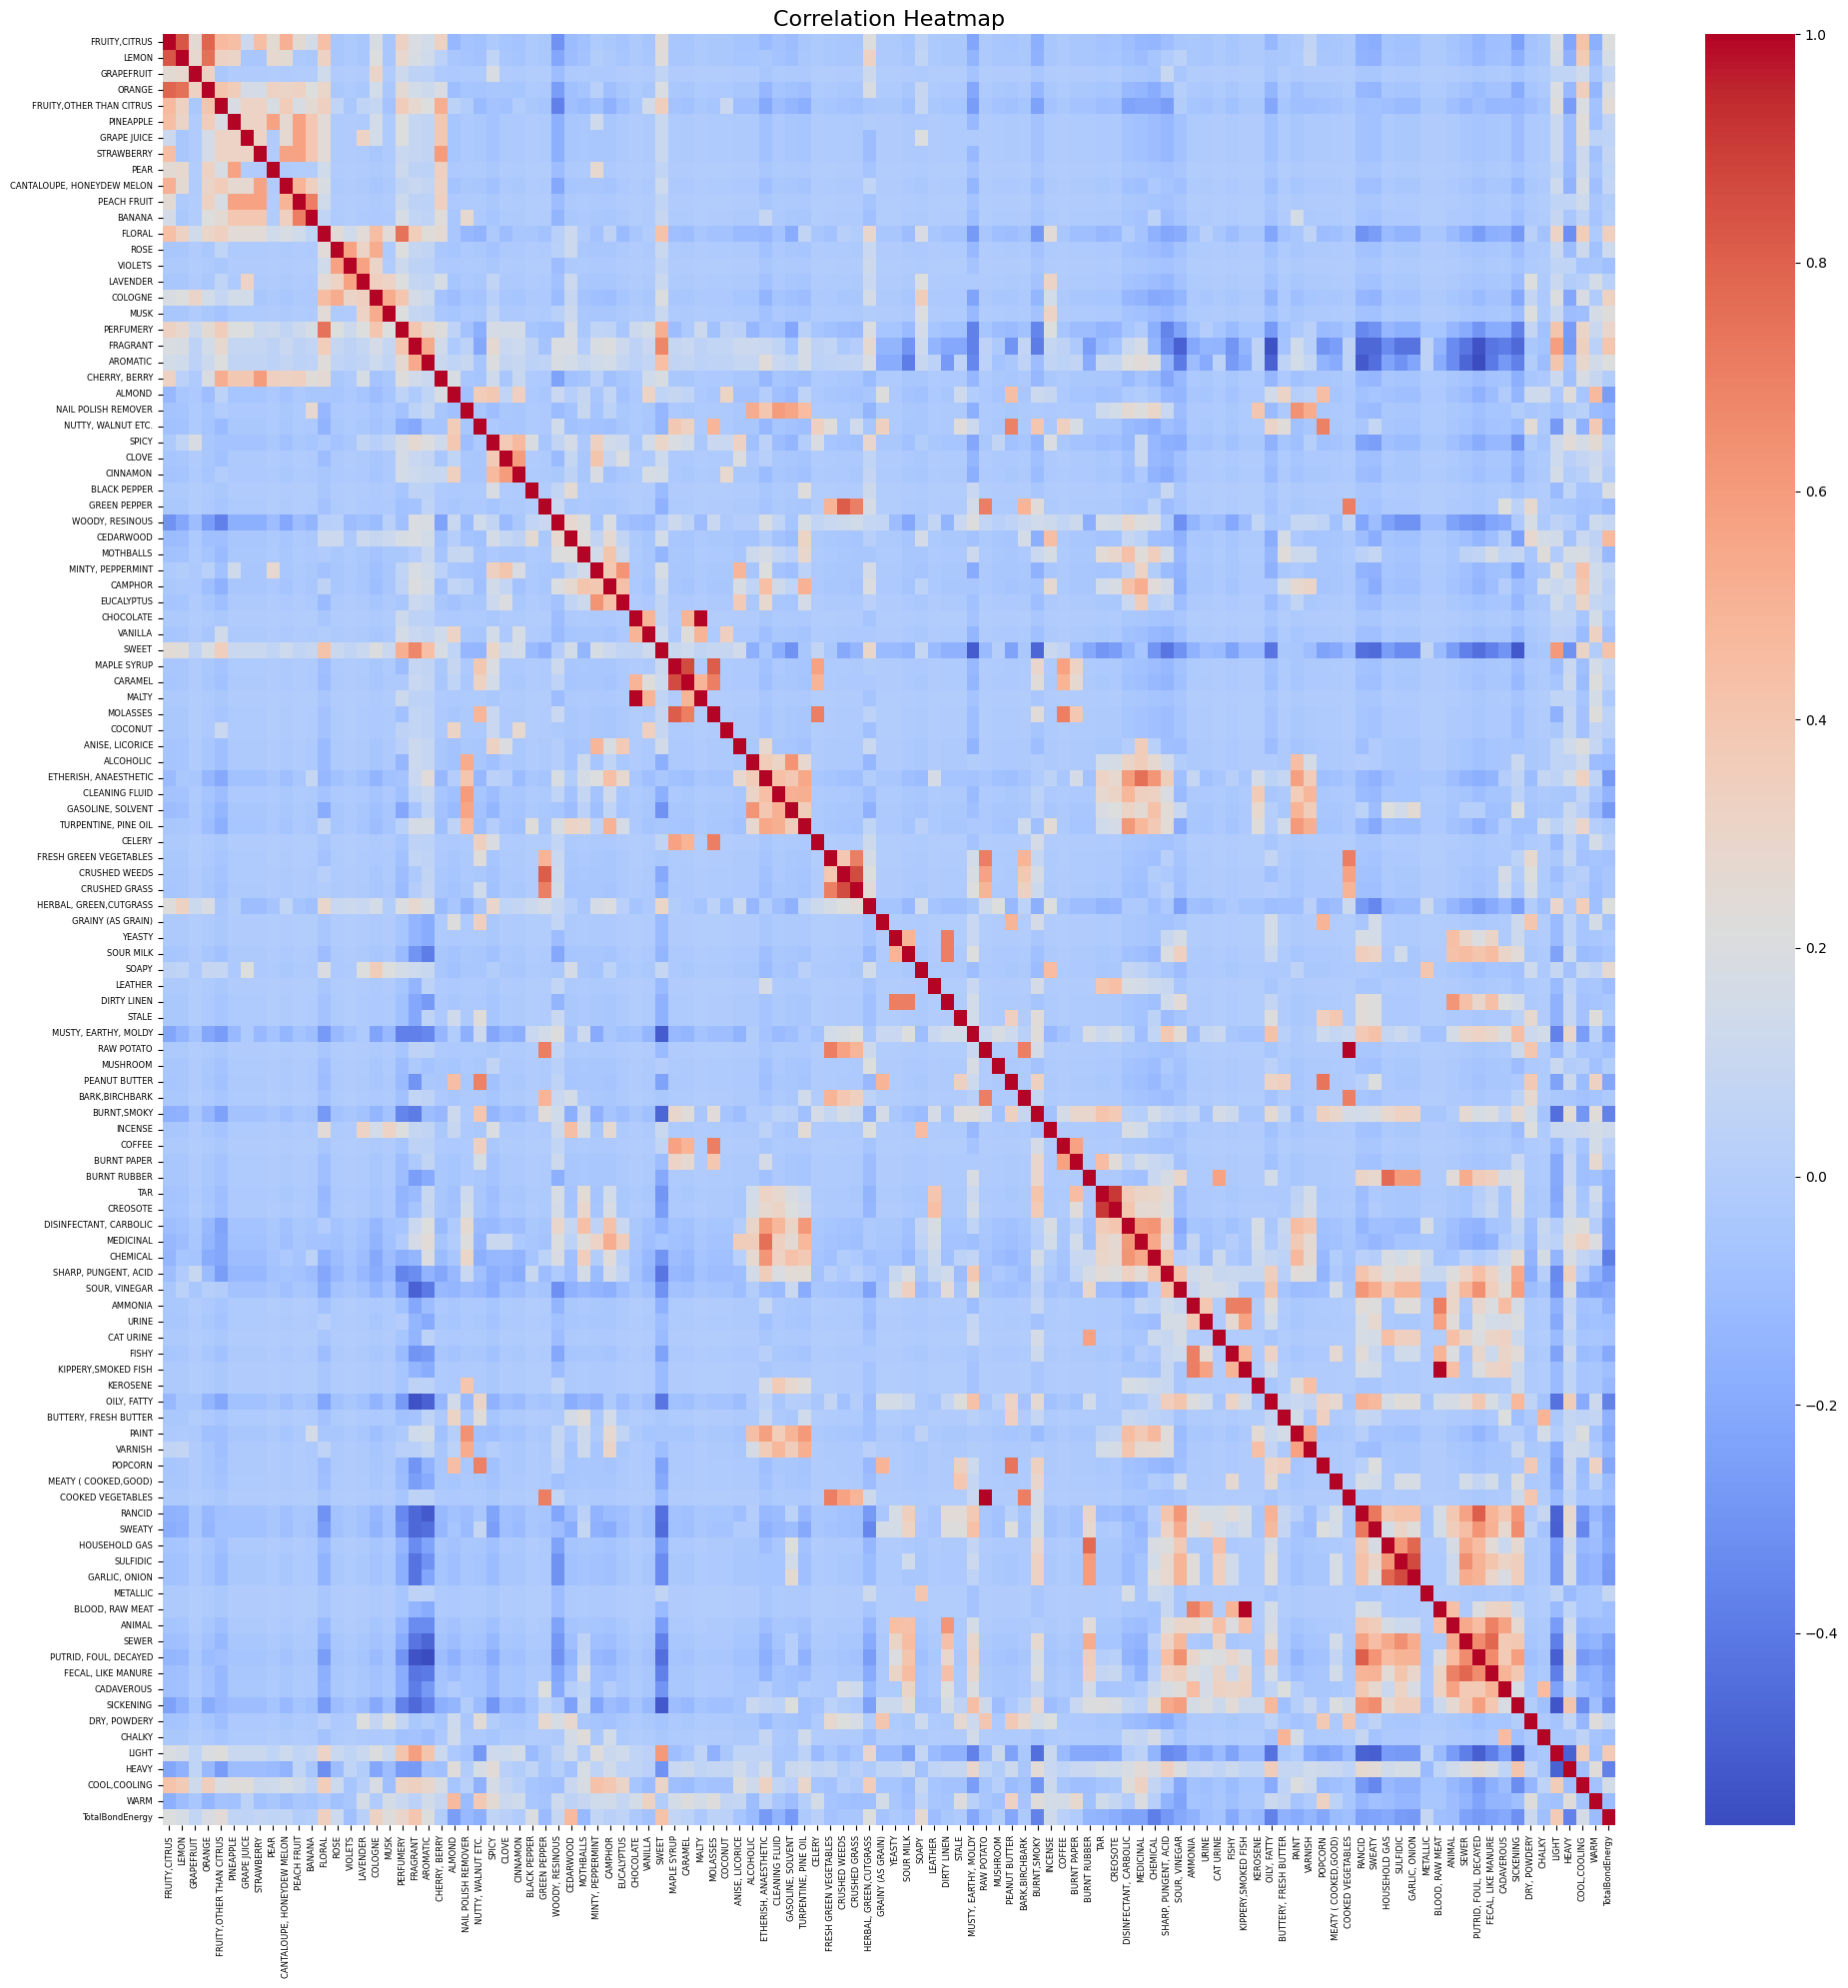

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

#This is much better, now we got eeeverything!
correlations = df_new.corr()


plt.figure(figsize=(20, 20))
sns.heatmap(correlations, cmap="coolwarm", annot=False, xticklabels=correlations.columns, yticklabels=correlations.columns)

#It's a wee bit big, but this captures all the perceptual features, shows their correlation to eachother.
#I think its a great way to appreciate the complexity of the data without loosing it's meaning
plt.xticks(fontsize=6, rotation=90)
plt.yticks(fontsize=6, rotation=0)
plt.title("Correlation Heatmap", fontsize=16)
plt.tight_layout()
plt.show()